# Notebook Information

Author: Elias Hossain (Graduate Student) <br>
Department: Electrical & Computer Engineering <br>
University: North South University <br>

## Purpose of the Notebook

This Jupyter Notebook was created for the CSE512 course assignment on distributed database management systems. The purpose of this notebook is to demonstrate the use of Python programming language and distributed computing techniques to implement a sales forecasting system for a retail chain.

## Notebook Contents

This notebook contains code, explanations, and examples related to the following topics:

- Database design and schema definition
- Data visualization, data transformation 
- Model evaluation and predictions
- Sales forecasting algorithms using machine learning techniques

The notebook applies machine learning algorithms to answer the following sales forecasting queries:

1. Forecast the one year sales (Breakdown monthly) for each of the items.
2. Forecast the sales of the stores for the next 30 days.

The notebook also includes examples of how to visualize the forecasted sales using Matplotlib and how to present the results in a user-friendly format.

## Instructions for Running the Notebook

To run this notebook, make sure you have Python 3 installed on your system along with the necessary packages such as NumPy, Pandas, Scikit-learn, and Matplotlib. You can install these packages using the following command:

```pip install numpy pandas scikit-learn matplotlib```

Once the required packages are installed, you can open the notebook in Jupyter Notebook or JupyterLab and run each cell in sequence to execute the code and see the results.


# Import Packages

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import psycopg2
import psycopg2.extras
import pandas as pd
from tqdm import tqdm
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# E-commerce Data Loader Class for PostgreSQL Database

In [2]:
class EcommerceDataLoader:
    """
    A class to load E-commerce data from a PostgreSQL database into Pandas DataFrames.
    """
    
    def __init__(self, host, port, username, password, database):
        """
        Initializes the EcommerceDataLoader class with the database connection parameters.
        """
        self.engine = create_engine(f'postgresql://{username}:{password}@{host}:{port}/{database}')
        
    def load_fact_table(self, schema):
        """
        Loads the fact table from the specified schema into a Pandas DataFrame.
        """
        query = f"SELECT * FROM {schema}.fact_table"
        return pd.read_sql_query(query, self.engine)
    
    def load_item_dim(self, schema):
        """
        Loads the item dimension table from the specified schema into a Pandas DataFrame.
        """
        query = f"SELECT * FROM {schema}.item_dim"
        return pd.read_sql_query(query, self.engine)
    
    def load_time_dim(self, schema):
        """
        Loads the time dimension table from the specified schema into a Pandas DataFrame.
        """
        query = f"SELECT * FROM {schema}.time_dim"
        return pd.read_sql_query(query, self.engine)
    
    def load_store_dim(self, schema):
        """
        Loads the store dimension table from the specified schema into a Pandas DataFrame.
        """
        query = f"SELECT * FROM {schema}.store_dim"
        return pd.read_sql_query(query, self.engine)
    
    
# create an instance of this class and use its methods
ecom_loader = EcommerceDataLoader('localhost', '5434', 'postgres', '1234', 'ecomdb')
fact_table = ecom_loader.load_fact_table('ecom_schema')
item_dim = ecom_loader.load_item_dim('ecom_schema')
time_dim = ecom_loader.load_time_dim('ecom_schema')
store_dim = ecom_loader.load_store_dim('ecom_schema')

# Function to merge E-commerce tables 

In [3]:
def merge_tables(fact_table, item_dim, time_dim, store_dim):
    """
    A function to merge the E-commerce tables.
    """
    merged_df = pd.merge(fact_table, item_dim, on='item_key', how='left')
    merged_df = pd.merge(merged_df, time_dim, on='time_key', how='left')
    merged_df = pd.merge(merged_df, store_dim, on='store_key', how='left')
    return merged_df

merged_df = merge_tables(fact_table, item_dim, time_dim, store_dim)

# Function to split data 

In [4]:
def split_data(df, train_size):
    """
    A function to split data into training and testing datasets.
    """
    train_size = int(len(df) * train_size)
    train_df = df[:train_size]
    test_df = df[train_size:]
    return train_df, test_df

train_df, test_df = split_data(merged_df, 0.8)

# SalesForecast: ARIMA Model

ARIMA is a form of regression analysis that indicates the strength of a dependent variable relative to other changing variables. The final objective of the model is to predict future time series movement by examining the differences between values in the series instead of through actual values. However, to answer the question no 1: "Forecast the one year sales (Breakdown monthly) for each of the items", we shall apply the ARIMA model and let's see the outcome.

# Forecast the one year sales (Breakdown monthly) for each of the items

In [5]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

class SalesForecastARIMA:
    def __init__(self, train_df):
        self.train_df = train_df
    
    def fit(self):
        # Convert the 'date' column to datetime format
        self.train_df['date'] = pd.to_datetime(self.train_df['date'])

        # Define the ARIMA model parameters
        p = 2  # AR term
        d = 1  # I term
        q = 2  # MA term

        # Group the training data by year and month
        train_data = self.train_df.groupby([self.train_df['date'].dt.year.rename('year'), self.train_df['date'].dt.month.rename('month'), 'item_key'])['total_price'].sum().reset_index()

        # Create a dictionary to store the forecasts for each item
        forecasts_dict = {}

        # Loop over each item and fit an ARIMA model
        for item in tqdm(train_data['item_key'].unique(), desc='Fitting ARIMA models'):
            # Subset the data for the current item
            item_data = train_data[train_data['item_key'] == item]

            # Fit the ARIMA model for the current item
            model = ARIMA(item_data['total_price'], order=(p, d, q)).fit()

            # Use the fitted model to make predictions for the next 12 months
            forecast = model.forecast(steps=12)

            # Add the forecast to the forecasts dictionary, using the item key as the key
            forecasts_dict[item] = forecast

        # Combine the forecasts into a single dataframe
        forecasts_df = pd.DataFrame(forecasts_dict)

        # Add a column for the year and month of each forecast
        forecasts_df['year'] = pd.date_range(start='2022-01-01', periods=12, freq='MS').year
        forecasts_df['month'] = pd.date_range(start='2022-01-01', periods=12, freq='MS').month

        # Reorder the columns to match the original data
        self.forecasts_df = forecasts_df[['year', 'month'] + train_data['item_key'].unique().tolist()]
    
    
    def fit_2(self):
        # Convert the 'date' column to datetime format
        self.train_df['date'] = pd.to_datetime(self.train_df['date'])

        # Define the ARIMA model parameters
        p = 2  # AR term
        d = 1  # I term
        q = 2  # MA term

        # Group the training data by year and month
        train_data = self.train_df.groupby([self.train_df['date'].dt.year.rename('year'), self.train_df['date'].dt.month.rename('month'), 'item_key'])['total_price'].sum().reset_index()

        # Create a dictionary to store the forecasts for each item
        forecasts_dict = {}

        # Loop over each item and fit an ARIMA model
        for item in tqdm(train_data['item_key'].unique(), desc='Fitting ARIMA models'):
            # Subset the data for the current item
            item_data = train_data[train_data['item_key'] == item]

            # Fit the ARIMA model for the current item
            model = ARIMA(item_data['total_price'], order=(p, d, q)).fit()

            # Use the fitted model to make predictions for the next 30 days
            forecast = model.forecast(steps=30)

            # Add the forecast to the forecasts dictionary, using the item key as the key
            forecasts_dict[item] = forecast

        # Combine the forecasts into a single dataframe
        forecasts_df = pd.DataFrame(forecasts_dict)

        # Add a column for the date of each forecast
        forecasts_df['date'] = pd.date_range(start='2022-01-01', periods=30, freq='D')

        # Reorder the columns to match the original data
        self.forecasts_df2 = forecasts_df[['date'] + train_data['item_key'].unique().tolist()]

        
        
    def predict(self):
        # Print the forecasts
        #print(self.forecasts_df.to_string(index=False))
        print(self.forecasts_df.head())
        
        
    def predict_2(self):
        
        print(self.forecasts_df2.head())
        
# Instantiate the model and fit the data
model = SalesForecastARIMA(train_df)
model.fit()

# Generate and print the forecasts
model.predict()

Fitting ARIMA models: 100%|██████████████████████████████████████████████████████████| 263/263 [00:35<00:00,  7.37it/s]

    year  month       I00001       I00002       I00003       I00004   
85  2022      1  2414.955529  1456.474529  1402.417480  1433.646680  \
86  2022      2  2821.038316  1463.229346  1374.710056  1361.885411   
87  2022      3  2329.700853  1456.710833  1476.664708  1450.874363   
88  2022      4  2777.644484  1460.975293  1395.694300  1415.372701   
89  2022      5  2381.995604  1458.029568  1475.612980  1439.952082   

         I00005       I00006       I00007       I00008  ...       I00255   
85  1657.218743  3436.594815  1294.135702  3053.322384  ...  4188.335983  \
86  1447.896971  3294.704982  1388.534292  3142.587383  ...  4443.488595   
87  1499.544349  3417.051666  1439.409787  3062.646541  ...  4206.546217   
88  1466.710754  3407.513326  1468.999209  3120.336707  ...  4410.613714   
89  1465.838971  3427.621320  1486.624605  3082.382294  ...  4235.048902   

         I00256       I00257       I00258       I00259       I00260   
85  4256.133100  4518.293361  4299.914901  51

# Sales Forecasting for Next 30 Days

In this section, we will use the SalesForecastARIMA class to generate sales forecasts for the next 30 days. The class has already been fitted to the training data, so we can simply call the predict2() method to generate the forecasts. We will then visualize the forecasts using a line chart to see the predicted sales trends for each store.

In [6]:
# Instantiate the model and fit the data
model = SalesForecastARIMA(train_df)
model.fit_2()

# Generate and print the forecasts
model.predict_2()

Fitting ARIMA models: 100%|██████████████████████████████████████████████████████████| 263/263 [00:38<00:00,  6.91it/s]


         date       I00001       I00002       I00003       I00004   
85 2022-01-01  2414.955529  1456.474529  1402.417480  1433.646680  \
86 2022-01-02  2821.038316  1463.229346  1374.710056  1361.885411   
87 2022-01-03  2329.700853  1456.710833  1476.664708  1450.874363   
88 2022-01-04  2777.644484  1460.975293  1395.694300  1415.372701   
89 2022-01-05  2381.995604  1458.029568  1475.612980  1439.952082   

         I00005       I00006       I00007       I00008       I00009  ...   
85  1657.218743  3436.594815  1294.135702  3053.322384  3585.371725  ...  \
86  1447.896971  3294.704982  1388.534292  3142.587383  3245.025704  ...   
87  1499.544349  3417.051666  1439.409787  3062.646541  3599.708034  ...   
88  1466.710754  3407.513326  1468.999209  3120.336707  3390.239835  ...   
89  1465.838971  3427.621320  1486.624605  3082.382294  3530.938341  ...   

         I00255       I00256       I00257       I00258       I00259   
85  4188.335983  4256.133100  4518.293361  4299.914901  5

# SalesForecast: Linear Regression Model

Linear regression is a data analysis technique that predicts the value of unknown data by using another related and known data value. It mathematically models the unknown or dependent variable and the known or independent variable as a linear equation. However, to answer the question no 1: "Forecast the one year sales (Breakdown monthly) for each of the items", we shall apply the Linear Regression model and let's see the outcome. 

# Forecast the one year sales (Breakdown monthly) for each of the items

In [7]:
class SalesForecastLinear:
    def __init__(self, train_df):
        self.train_df = train_df
    
        
    def fit_linear(self):
        # Convert the 'date' column to datetime format
        self.train_df['date'] = pd.to_datetime(self.train_df['date'])

        # Group the training data by year and month
        train_data = self.train_df.groupby([self.train_df['date'].dt.year.rename('year'), self.train_df['date'].dt.month.rename('month'), 'item_key'])['total_price'].sum().reset_index()

        # Create a dictionary to store the forecasts for each item
        forecasts_dict = {}

        # Loop over each item and fit a Linear Regression model
        for item in tqdm(train_data['item_key'].unique(), desc='Fitting Linear Regression models'):
            # Subset the data for the current item
            item_data = train_data[train_data['item_key'] == item]

            # Create a Linear Regression model for the current item
            model = LinearRegression()

            # Prepare the training data
            X_train = item_data[['year', 'month']]
            y_train = item_data['total_price']

            # Fit the Linear Regression model for the current item
            model.fit(X_train, y_train)

            # Use the fitted model to make predictions for the next 12 months
            X_test = pd.DataFrame({'year': [2022]*12, 'month': range(1,13)})
            forecast = model.predict(X_test)

            # Add the forecast to the forecasts dictionary, using the item key as the key
            forecasts_dict[item] = forecast

        # Combine the forecasts into a single dataframe
        forecasts_df = pd.DataFrame(forecasts_dict)

        # Add a column for the year and month of each forecast
        forecasts_df['year'] = pd.date_range(start='2022-01-01', periods=12, freq='MS').year
        forecasts_df['month'] = pd.date_range(start='2022-01-01', periods=12, freq='MS').month

        # Reorder the columns to match the original data
        self.forecasts_df = forecasts_df[['year', 'month'] + train_data['item_key'].unique().tolist()]
    
    def fit_linear_2(self):
        # Convert the 'date' column to datetime format
        self.train_df['date'] = pd.to_datetime(self.train_df['date'])

        # Group the training data by year, month, and store
        train_data = self.train_df.groupby([self.train_df['date'].dt.year.rename('year'), self.train_df['date'].dt.month.rename('month'), 'store_key'])['total_price'].sum().reset_index()

        # Create a dictionary to store the forecasts for each store
        store_forecasts_dict = {}

        # Loop over each store and fit a Linear Regression model
        for store in tqdm(train_data['store_key'].unique(), desc='Fitting Linear Regression models'):
            # Subset the data for the current store
            store_data = train_data[train_data['store_key'] == store]

            # Create a linear regression model
            model = LinearRegression()

            # Train the model on the training data
            X = store_data[['year', 'month']]
            y = store_data['total_price']
            model.fit(X, y)

            # Use the trained model to make predictions for the next 30 days
            next_month_year = store_data['year'].max()
            next_month_month = store_data['month'].max() + 1
            if next_month_month > 12:
                next_month_month = 1
                next_month_year += 1
            forecast_dates = pd.DataFrame({'year': [next_month_year], 'month': [next_month_month]})
            forecast = model.predict(forecast_dates)

            # Add the forecast to the store_forecasts dictionary, using the store key as the key
            store_forecasts_dict[store] = forecast

        # Combine the forecasts for all stores into a single dataframe
        self.store_forecasts_df = pd.DataFrame(store_forecasts_dict)

        # Add a column for the date of each forecast
        self.store_forecasts_df['date'] = pd.date_range(start='2022-03-01', periods=1, freq='D')

        # Set the date column as the index of the store_forecasts_df dataframe
        self.store_forecasts_df = self.store_forecasts_df.set_index('date')

        
    def predict(self):
        # Print the forecasts
        print(self.forecasts_df.head())
        
        
    def predict_2(self):
        # Print the forecasts
        #print(self.store_forecasts_df.head())
        print(self.store_forecasts_df.to_string())

# Instantiate the model and fit the data using ARIMA
model = SalesForecastLinear(train_df)

# Fit the linear regression models and generate the forecasts
model.fit_linear()
model.predict()

Fitting Linear Regression models: 100%|█████████████████████████████████████████████| 263/263 [00:01<00:00, 145.52it/s]

   year  month       I00001       I00002       I00003       I00004   
0  2022      1  2442.460564  1387.201204  1431.333482  1406.176666  \
1  2022      2  2449.416539  1392.014861  1437.956372  1412.348978   
2  2022      3  2456.372514  1396.828518  1444.579261  1418.521291   
3  2022      4  2463.328490  1401.642175  1451.202151  1424.693603   
4  2022      5  2470.284465  1406.455832  1457.825041  1430.865916   

        I00005       I00006       I00007       I00008  ...       I00255   
0  1379.472366  3309.960484  1578.564312  3337.137861  ...  4366.032613  \
1  1402.522847  3345.803412  1573.943218  3349.720306  ...  4410.928826   
2  1425.573327  3381.646340  1569.322123  3362.302750  ...  4455.825039   
3  1448.623807  3417.489268  1564.701029  3374.885194  ...  4500.721252   
4  1471.674287  3453.332197  1560.079935  3387.467639  ...  4545.617465   

        I00256       I00257       I00258       I00259       I00260   
0  3783.309724  4464.678256  4336.361450  5040.260094  349

# Sales Forecasting for Next 30 Days

In this section, we will use the SalesForecastLinear class to generate sales forecasts for the next 30 days. The class has already been fitted to the training data, so we can simply call the predict_2() method to generate the forecasts. We will then visualize the forecasts using a line chart to see the predicted sales trends for each store.

In [8]:
# Instantiate the model and fit the data
model2 = SalesForecastLinear(train_df)
model2.fit_linear_2()
# Generate and print the forecasts
model2.predict_2()

Fitting Linear Regression models: 100%|██████████████████████████████████████████████| 726/726 [00:08<00:00, 89.96it/s]


                  S0001        S0002        S0003        S0004        S0006        S0007       S0008        S0009        S0010       S00100       S00101       S00102       S00103       S00104       S00105       S00106       S00107       S00108       S00109        S0011       S00110       S00111      S00112       S00113       S00114       S00115       S00116      S00117       S00118       S00119        S0012       S00120       S00121       S00122       S00123       S00124       S00125       S00126      S00127       S00128       S00129        S0013       S00130       S00131       S00132       S00133       S00134       S00135       S00136       S00137       S00138       S00139       S0014       S00140       S00141       S00142       S00143      S00144       S00145       S00146       S00147       S00148       S00149        S0015      S00150       S00151      S00152       S00153       S00154       S00155       S00156      S00157       S00158       S00159        S0016       S00160       S001

# Exploratory Data Analysis (EDA)

The goal of EDA is to identify patterns, relationships, and insights in the data, and to understand the underlying structure and nature of the variables. EDA typically involves visualizing the data using various graphs and charts, calculating descriptive statistics such as mean, median, and standard deviation, and detecting outliers and missing values. By performing EDA, data analysts and scientists can gain a deeper understanding of the data and make more informed decisions about modeling and analysis techniques.

### EDA1—Monthly sales forecast for each item

Fitting ARIMA models: 100%|██████████████████████████████████████████████████████████| 263/263 [00:37<00:00,  6.97it/s]


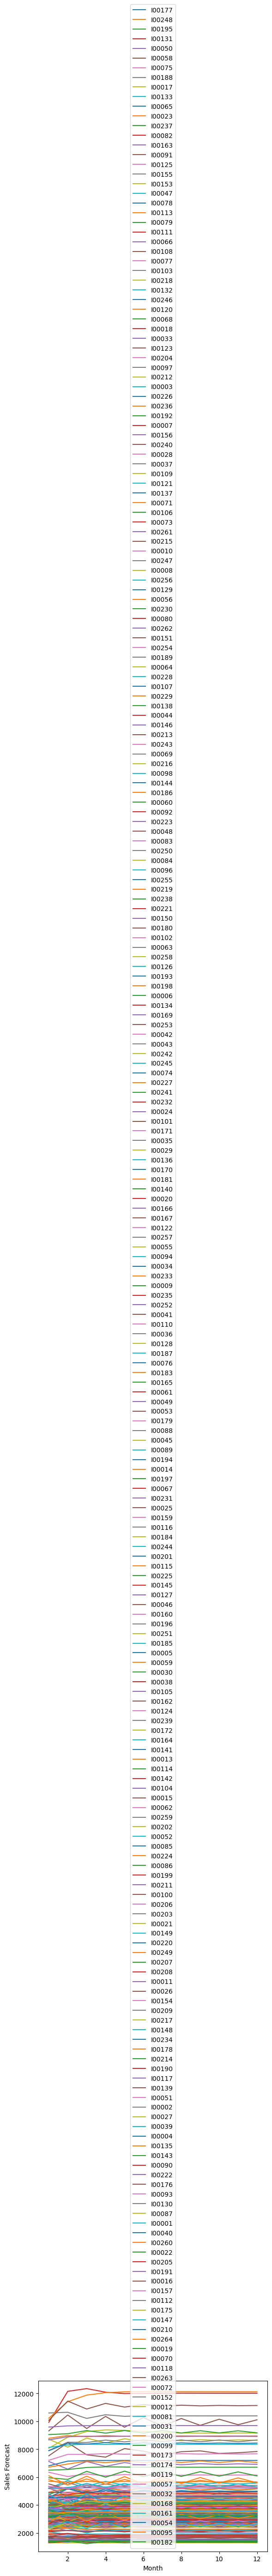

In [9]:
def plot_forecasts(model_instance):
    fig, ax = plt.subplots()

    for item in model_instance.train_df['item_key'].unique():
        ax.plot(model_instance.forecasts_df['month'], model_instance.forecasts_df[item], label=item)

    ax.set_xlabel('Month')
    ax.set_ylabel('Sales Forecast')
    ax.legend()

    plt.show()
    
model = SalesForecastARIMA(train_df)
model.fit()

plot_forecasts(model)

### EDA2— What is the total sales forecast for each month and how each item contributes to it?

Fitting ARIMA models: 100%|██████████████████████████████████████████████████████████| 263/263 [00:38<00:00,  6.92it/s]


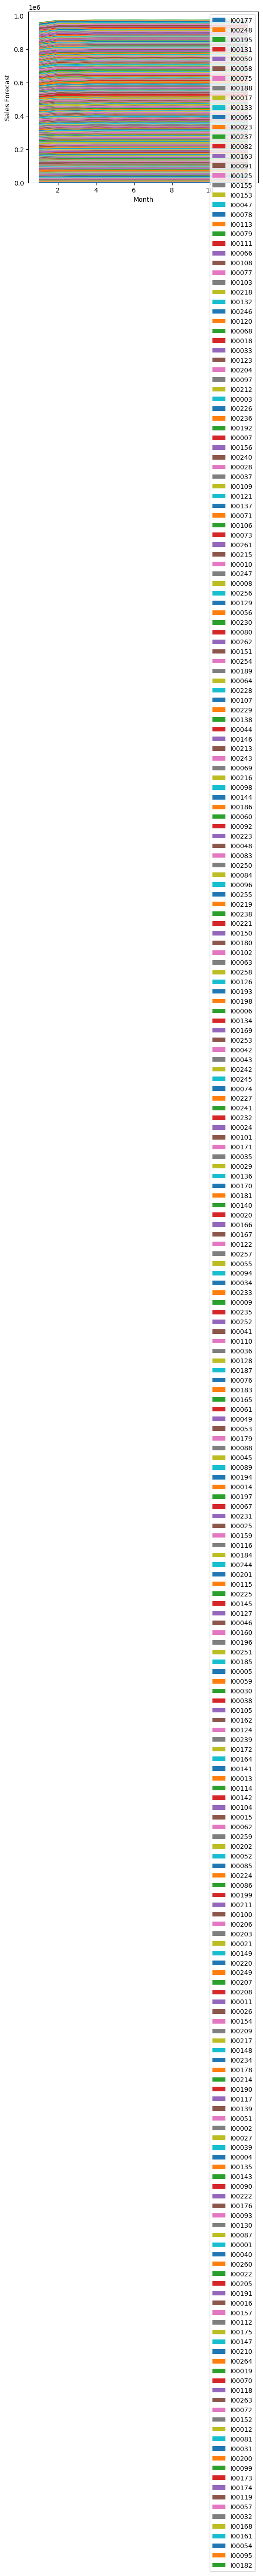

In [10]:
def plot_forecast_area(model_instance):
    fig, ax = plt.subplots()
    
    ax.stackplot(model_instance.forecasts_df['month'], model_instance.forecasts_df[train_df['item_key'].unique().tolist()].transpose(), labels=model_instance.train_df['item_key'].unique().tolist())

    ax.set_xlabel('Month')
    ax.set_ylabel('Sales Forecast')
    ax.legend()

    plt.show()

    
model = SalesForecastARIMA(train_df)
model.fit()

plot_forecast_area(model)

### EDA3—Visualize the monthly sales forecast for each item

Fitting ARIMA models: 100%|██████████████████████████████████████████████████████████| 263/263 [00:38<00:00,  6.85it/s]


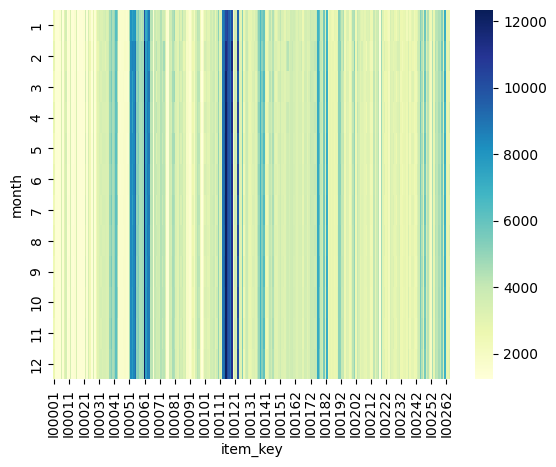

In [11]:
def visualize_monthly_sales(model_instance):
    
    item_forecasts_df = model_instance.forecasts_df.melt(id_vars=['year', 'month'], value_vars=model_instance.train_df['item_key'].unique().tolist(), var_name='item_key', value_name='sales_forecast')
    sns.heatmap(item_forecasts_df.pivot(index='month', columns='item_key', values='sales_forecast'), cmap='YlGnBu')
    plt.show()

        
model = SalesForecastARIMA(train_df)
model.fit()

visualize_monthly_sales(model)

### EDA4—Forecast sales by item

Fitting ARIMA models: 100%|██████████████████████████████████████████████████████████| 263/263 [00:40<00:00,  6.51it/s]


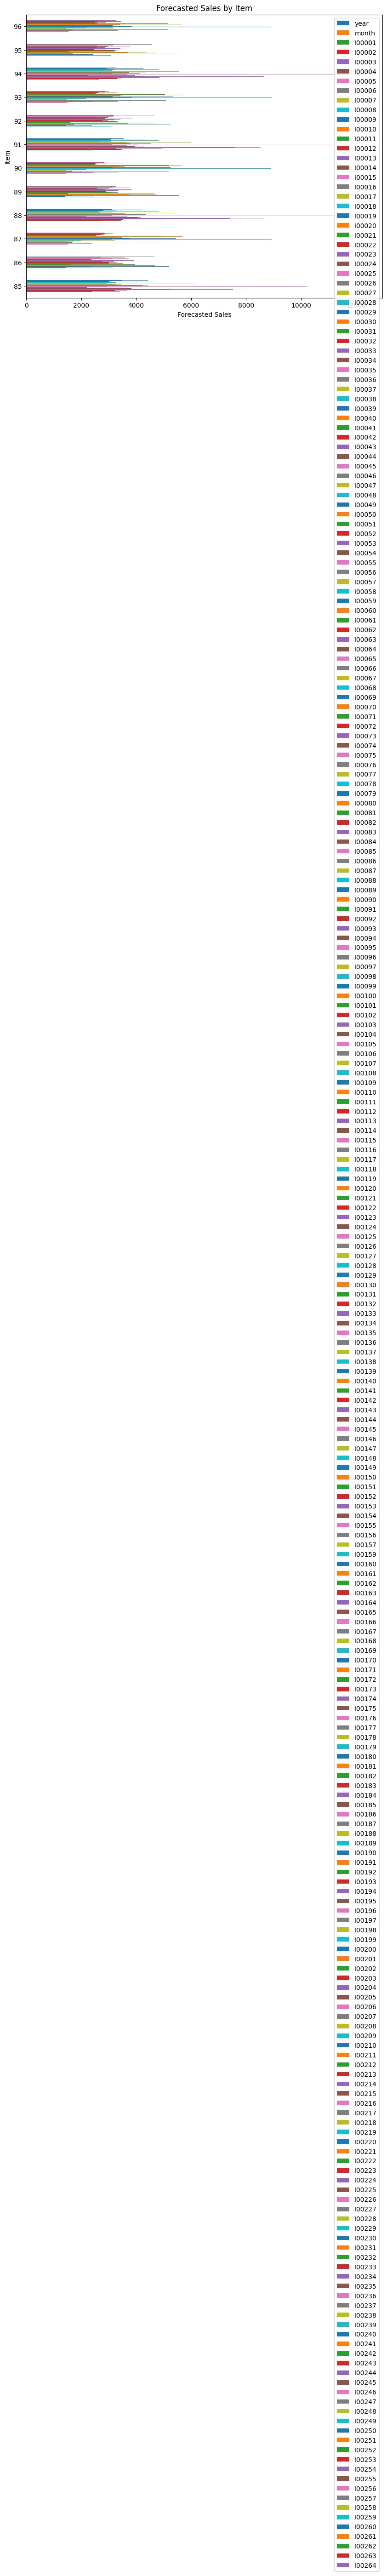

In [12]:
def forecast_sales_by_item(model_instance):
    
    # Reset the index of the forecasts_df dataframe
    forecasts_df = model_instance.forecasts_df.reset_index()

    # Create a horizontal bar chart of the forecasted sales for each item
    ax = forecasts_df.plot(kind='barh', x='index', figsize=(10, 8))

    # Set the axis labels and title
    ax.set_xlabel('Forecasted Sales')
    ax.set_ylabel('Item')
    ax.set_title('Forecasted Sales by Item')

    # Display the plot
    plt.show()
    
model = SalesForecastARIMA(train_df)
model.fit()

forecast_sales_by_item(model)